In [1]:
## Load required libraries and datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import re
from collections import Counter
from scipy.stats import t
from statistics import stdev

import matplotlib.dates as mdates
import missingno

#remove all warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
## import data
all_data=pd.read_csv("./csv_folders/QVI_data.csv")
all_data.head(5)

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [3]:
all_data.shape

(264834, 12)

<AxesSubplot:>

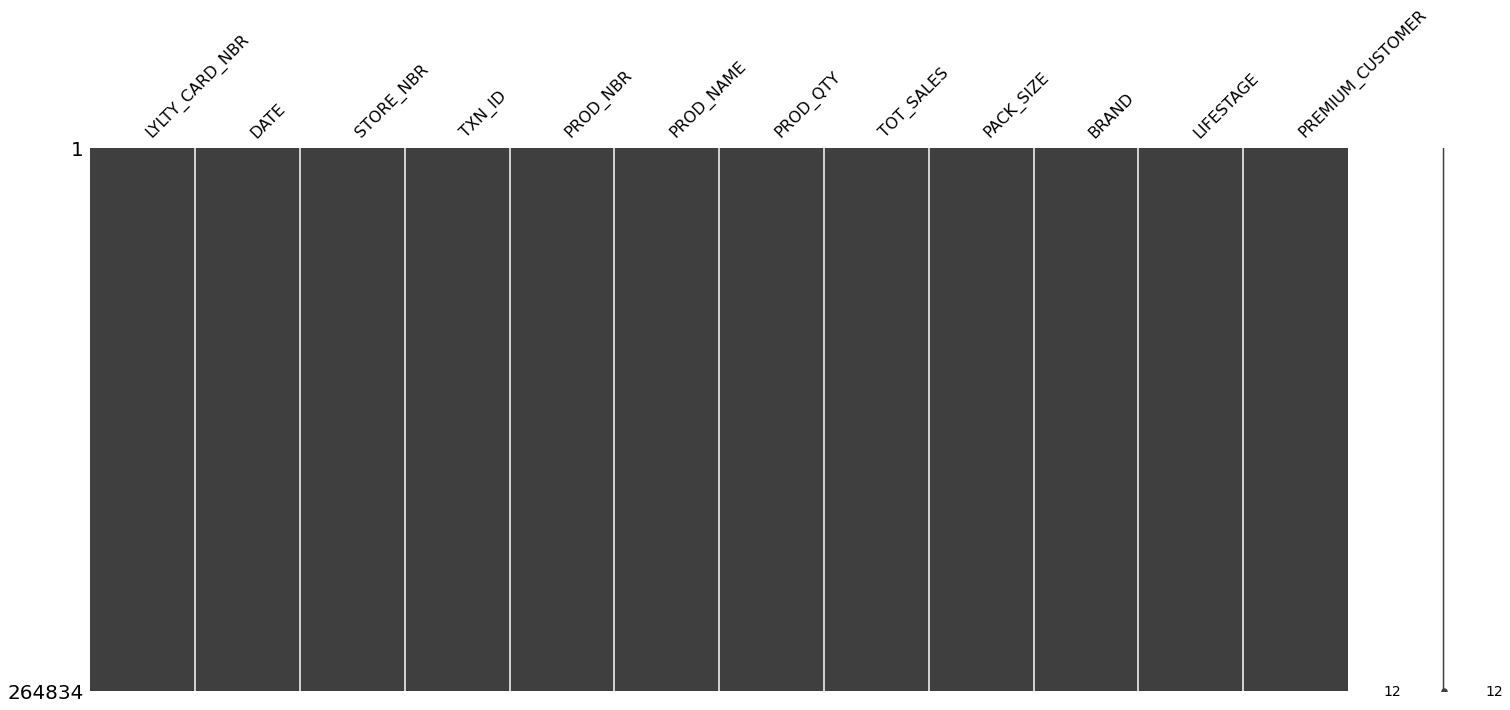

In [4]:
##checking missing values and duplicates
missingno.matrix(all_data)

## Select control stores
The client has selected store numbers 77, 86 and 88 as trial stores and want
control stores to be established stores that are operational for the entire
observation period.
We would want to match trial stores to control stores that are similar to the trial
store prior to the trial period of Feb 2019 in terms of :
- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer

In [16]:
## Create Yearmonth feature
all_data["YEARMONTH"]=[''.join(x.split('-')[0:2]) for x in all_data["DATE"]]
all_data["YEARMONTH"]=pd.to_numeric(all_data["YEARMONTH"])
all_data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEARMONTH
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,201810
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,201809
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,201903
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,201903
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,201811


In [17]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
 12  YEARMONTH         264834 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 21.2+ MB


 For each store and month calculate
 - total sales
 - number of customers
 - transactions per customer
 - chips per customer
 -average price per unit

In [21]:
## totoal sales
totSales=all_data.groupby(["STORE_NBR","YEARMONTH"]).TOT_SALES.sum()
totSales

STORE_NBR  YEARMONTH
1          201807       206.9
           201808       176.1
           201809       278.8
           201810       188.1
           201811       192.6
                        ...  
272        201902       395.5
           201903       442.3
           201904       445.1
           201905       314.6
           201906       312.1
Name: TOT_SALES, Length: 3169, dtype: float64

In [24]:
## number of customers
numCust=all_data.groupby(["STORE_NBR","YEARMONTH"]).LYLTY_CARD_NBR.nunique()
numCust

STORE_NBR  YEARMONTH
1          201807       49
           201808       42
           201809       59
           201810       44
           201811       46
                        ..
272        201902       45
           201903       50
           201904       54
           201905       34
           201906       34
Name: LYLTY_CARD_NBR, Length: 3169, dtype: int64

In [26]:
## transactin per customer
## unique transaction ID divided by unique loyalty card number
transPerCust=all_data.groupby(["STORE_NBR","YEARMONTH"]).TXN_ID.nunique()/all_data.groupby(["STORE_NBR","YEARMONTH"]).LYLTY_CARD_NBR.nunique()
transPerCust

STORE_NBR  YEARMONTH
1          201807       1.061224
           201808       1.023810
           201809       1.050847
           201810       1.022727
           201811       1.021739
                          ...   
272        201902       1.066667
           201903       1.060000
           201904       1.018519
           201905       1.176471
           201906       1.088235
Length: 3169, dtype: float64

In [27]:
## chips per customers
## TOTAL_SALES divided by PROD_QTY
avgPricePerCust=all_data.groupby(["STORE_NBR","YEARMONTH"]).TOT_SALES.sum()/all_data.groupby(["STORE_NBR","YEARMONTH"]).PROD_QTY.sum()
avgPricePerCust

STORE_NBR  YEARMONTH
1          201807       3.337097
           201808       3.261111
           201809       3.717333
           201810       3.243103
           201811       3.378947
                          ...   
272        201902       4.346154
           201903       4.379208
           201904       4.239048
           201905       4.430986
           201906       4.458571
Length: 3169, dtype: float64

In [30]:
# combine all
dataframes=[totSales,numCust,transPerCust,avgPricePerCust]
measure_over_time=pd.concat(dataframes,join='outer',axis=1)
measure_over_time.rename(columns={"TOT_SALES":'totSales',"LYLTY_CARD_NBR":"numCust",0:"transPerCust",1:"avgPricePerCust"},inplace=True)
measure_over_time

totSales  numCust  transPerCust  avgPricePerCust
STORE_NBR YEARMONTH                                                  
1         201807        206.9       49      1.061224         3.337097
          201808        176.1       42      1.023810         3.261111
          201809        278.8       59      1.050847         3.717333
          201810        188.1       44      1.022727         3.243103
          201811        192.6       46      1.021739         3.378947
...                       ...      ...           ...              ...
272       201902        395.5       45      1.066667         4.346154
          201903        442.3       50      1.060000         4.379208
          201904        445.1       54      1.018519         4.239048
          201905        314.6       34      1.176471         4.430986
          201906        312.1       34      1.088235         4.458571

[3169 rows x 4 columns]